# Definition of the Tubular Origami Map

## Setup of the Map Function

In [178]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

# --- Helper Functions ---

@njit
def rotation_matrix_x(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    return np.array([
        [1.0, 0.0, 0.0],
        [0.0, c, -s],
        [0.0, s, c]
    ])

@njit
def check_domain(val_sq):
    if val_sq < 0:
        return np.nan
    return np.sqrt(val_sq)

@njit
def calc_alpha_beta(I, l_L, l_R):
    denom = 2 * l_L * (2 * I)
    if denom == 0: return np.nan, np.nan

    alpha = (l_L**2 + (2 * I)**2 - l_R**2) / denom
    val_sq = 1 - alpha**2
    if val_sq < 0: return np.nan, np.nan

    beta = np.sqrt(val_sq)
    return alpha, beta

# --- Map f (Folding Map) ---

@njit
def map_f(theta, I, l_L, l_R, r1, r2, r3, N, sigma):
    """
    Map f: Folding Map defined in Thesis Eq. 3.1 - 3.7
    Inputs:
      theta, I: Current state
      l_L, l_R: Current zigzag edge lengths (Input geometry)
      r1, r2, r3: Radii for intersection (Target geometry: r1=Right, r2=Mid, r3=Left of next)
      N: Number of modules
      sigma: Mountain/Valley assignment (+1/-1)
    """
    # 1. Check Domain
    if not (abs(l_L - l_R)/2 < I < (l_L + l_R)/2):
        return np.nan, np.nan

    # 2. Calculate Basis (e1, e2, e3)
    alpha, beta = calc_alpha_beta(I, l_L, l_R)
    if np.isnan(alpha): return np.nan, np.nan

    sin_th = np.sin(theta)
    cos_th = np.cos(theta)

    # Basis vectors (Eq 2.11)
    e1_vec = np.array([beta * cos_th, -alpha, beta * sin_th])
    e2_vec = np.array([-alpha * cos_th, -beta, -alpha * sin_th])
    e3_vec = np.array([sin_th, 0.0, -cos_th])

    basis_matrix = np.stack((e1_vec, e2_vec, e3_vec), axis=1)

    # 3. Calculate Coefficients (Eq 2.13-2.15)
    e1_coeff = (r1**2 + l_L**2 - r2**2) / (2 * l_L)

    term_e2_num = r1**2 - r3**2 + 4*I**2 - 4*I*e1_coeff*alpha
    term_e2_den = 4 * I * beta
    if term_e2_den == 0: return np.nan, np.nan
    e2_coeff = term_e2_num / term_e2_den

    gamma = r1**2 - e1_coeff**2 - e2_coeff**2
    sqrt_gamma = check_domain(gamma)
    if np.isnan(sqrt_gamma): return np.nan, np.nan
    e3_coeff = sigma * sqrt_gamma

    coeffs = np.array([e1_coeff, e2_coeff, e3_coeff])

    # 4. Calculate Vector u (Eq 3.4)
    vec_V_local = basis_matrix @ coeffs

    rot = rotation_matrix_x(2 * np.pi / N)
    identity = np.eye(3)
    rot_diff = rot - identity

    vec_U1_U3 = np.array([0.0, -2.0 * I, 0.0])
    u = vec_U1_U3 + rot_diff @ vec_V_local

    # --- Dot Product Cutoff (Singularity Check) ---
    pi_over_N = np.pi / N
    n_vector = np.array([0.0, np.cos(pi_over_N), np.sin(pi_over_N)])
    if np.dot(u, n_vector) > 0:
        return np.nan, np.nan
    # ----------------------------------------------

    norm_u = np.linalg.norm(u)
    if norm_u == 0: return np.nan, np.nan
    I_new = 0.5 * norm_u

    # 5. Calculate Vector v (Eq 3.5)
    alpha_new = (r3**2 + (2*I_new)**2 - r1**2) / (2 * r3 * (2*I_new))
    v = vec_U1_U3 - vec_V_local - alpha_new * u

    norm_v = np.linalg.norm(v)
    if norm_v == 0: return np.nan, np.nan

    # 6. Update Theta (Eq 3.2)
    v_hat = v / norm_v
    u_hat = u / norm_u
    e_X = np.array([1.0, 0.0, 0.0])

    cross_term = np.cross(e_X, v_hat)
    y_val = np.dot(cross_term, u_hat)
    x_val = np.dot(e_X, v_hat)

    theta_new = np.arctan2(y_val, x_val)

    return theta_new, I_new

# --- Map g (Connectivity Transformation) ---

@njit
def map_g(theta, I, r3, r1, N):
    """
    Map g: Connectivity Transformation defined in Thesis Eq. 3.9 - 3.14
    Note on parameters:
    The thesis defines g(x; r3, r1, N).
    When connecting zigzag i to i+1, if g is applied, it takes the
    Left and Right edge lengths of zigzag i+1.
    Specifically: r3 = l_{i+1, L}, r1 = l_{i+1, R}.
    """
    sin_pi_N = np.sin(np.pi / N)
    cot_pi_N = 1.0 / np.tan(np.pi / N)

    # T1 (Eq 3.11)
    # 16 * I^2 * r3^2 - (4*I^2 + r3^2 - r1^2)^2
    term_inside_sqrt = 16 * I**2 * r3**2 - (4*I**2 + r3**2 - r1**2)**2
    sqrt_T1 = check_domain(term_inside_sqrt)
    if np.isnan(sqrt_T1): return np.nan, np.nan
    T1 = sqrt_T1

    # T2 (Eq 3.12)
    T2 = 4 * I**2 * cot_pi_N + T1 * np.sin(theta)

    # I_star (Eq 3.10)
    term_I = (r3**2 - r1**2)**2 + T2**2
    I_star = (sin_pi_N / (4 * I)) * np.sqrt(term_I)

    # Y_g (Eq 3.13)
    Y_g = -sin_pi_N * (T2 * (T1 * cot_pi_N * np.sin(theta) - 4 * I**2) + (r1**2 - r3**2)**2 * cot_pi_N)

    # X_g (Eq 3.14)
    # Note: Thesis Eq 3.14 uses cos(theta)
    X_g = -T1 * np.cos(theta) * np.sqrt((r3**2 - r1**2)**2 + T2**2)

    # Theta_star (Eq 3.9)
    theta_star = np.arctan2(Y_g, X_g)

    return theta_star, I_star

@njit
def lambda_map(theta, I, s, mu):
    return theta, I / s + mu

# --- Main Simulation Logic ---

def run_origami_simulation(params):
    m = params['m']
    N = params['N']
    s_val = params.get('s', 1.0)
    mu_val = params.get('mu', 0.0)

    l_L = np.array(params['l_L'], dtype=np.float64)
    l_M = np.array(params['l_M'], dtype=np.float64)
    l_R = np.array(params['l_R'], dtype=np.float64)
    sigmas = np.array(params['sigma'], dtype=np.float64)
    ks = np.array(params['k'], dtype=np.int32)

    plot_cfg = params['plot_config']
    iterations = plot_cfg['iterations']
    theta_rng = plot_cfg['theta_range']
    I_rng = plot_cfg['I_range']

    # Initial Conditions setup (omitted for brevity, same as before)
    # ... (Assume initial_conditions list is prepared) ...
    ic_param = params.get('initial_conditions', [])
    initial_conditions = []
    if isinstance(ic_param, list):
        initial_conditions = ic_param
    elif isinstance(ic_param, dict) and ic_param.get('type') == 'grid':
        # Simple grid generation
        t_vals = np.linspace(ic_param['theta_range'][0], ic_param['theta_range'][1], ic_param['theta_steps'])
        i_vals = np.linspace(ic_param['I_range'][0], ic_param['I_range'][1], ic_param['I_steps'])
        for t in t_vals:
            for i in i_vals:
                initial_conditions.append((t, i))

    all_trajectories = []

    @njit
    def step_map(theta, I):
        curr_theta, curr_I = theta, I

        # Flag to track leg swapping.
        # False (Normal): Left is Left, Right is Right.
        # True (Swapped): Left is Right, Right is Left.
        swapped = False

        for i in range(m):
            next_i = (i + 1) % m

            # 1. Determine Input Geometry (Current Zigzag) based on Swap State
            if swapped:
                curr_l_L = l_R[i]
                curr_l_R = l_L[i]
            else:
                curr_l_L = l_L[i]
                curr_l_R = l_R[i]

            # 2. Determine Target Geometry (Next Zigzag Radii)
            # Apply scaling s only at the boundary (last step i = m-1)
            scale = s_val if (i == m - 1) else 1.0

            # Map f always targets the "Normal" orientation of the next zigzag.
            # Radii order for f is always: r1=Right, r2=Middle, r3=Left (of the next zigzag)
            # (See Thesis Eq 3.20, 3.23, 3.25)
            r1 = l_R[next_i] * scale
            r2 = l_M[next_i]
            r3 = l_L[next_i] * scale

            # 3. Apply Map f
            # f maps from H(curr_L, curr_R) -> H(r3, r1) = H(next_L, next_R)
            # So f always resets the state to "Normal" (Left=Left, Right=Right).
            curr_theta, curr_I = map_f(
                curr_theta, curr_I,
                curr_l_L, curr_l_R,
                r1, r2, r3,
                N, sigmas[i]
            )

            if np.isnan(curr_I): return np.nan, np.nan

            # After f, we are in Normal state
            swapped = False

            # 4. Apply Map g if k_i == 1
            if ks[i] == 1:
                # g maps from H(L, R) -> H(R, L)
                # It swaps the orientation for the *next* step.

                # Parameters for g are the L and R of the current state (which matches next zigzag's L, R)
                # Thesis 3.8 defines g(x; r3, r1) where r3=L, r1=R.
                g_r3 = l_L[next_i] * scale
                g_r1 = l_R[next_i] * scale

                curr_theta, curr_I = map_g(
                    curr_theta, curr_I,
                    g_r3, g_r1,
                    N
                )

                if np.isnan(curr_I): return np.nan, np.nan

                # After g, legs are swapped
                swapped = True

        # Apply Lambda (Drift)
        curr_theta, curr_I = lambda_map(curr_theta, curr_I, s_val, mu_val)

        # Normalize angle
        curr_theta = (curr_theta + np.pi) % (2 * np.pi) - np.pi

        return curr_theta, curr_I

    # --- Simulation Loop (Same as before) ---
    for ic in initial_conditions:
        theta0, I0 = ic
        traj_theta = np.zeros(iterations)
        traj_I = np.zeros(iterations)
        t, i_val = theta0, I0

        for step in range(iterations):
            traj_theta[step] = t
            traj_I[step] = i_val
            t_next, i_next = step_map(t, i_val)
            if np.isnan(i_next):
                # Terminate and don't show incomplete trajectories
                traj_theta = np.zeros(0)
                traj_I = np.zeros(0)
                break
            t, i_val = t_next, i_next

        if len(traj_theta) > 0:
            all_trajectories.append((traj_theta, traj_I))

    # --- Plotting ---
    plt.figure(figsize=(10, 8))
    x_is_theta = (plot_cfg['x_axis'] == 'theta')
    marker_size = 0.5 if len(initial_conditions) < 50 else 0.1

    for th_arr, i_arr in all_trajectories:
        if x_is_theta:
            plt.scatter(th_arr, i_arr, s=marker_size)
        else:
            plt.scatter(i_arr, th_arr, s=marker_size)

    if x_is_theta:
        plt.xlabel(r"$\theta$"); plt.ylabel(r"$I$")
        plt.xlim(theta_rng); plt.ylim(I_rng)
    else:
        plt.xlabel(r"$I$"); plt.ylabel(r"$\theta$")
        plt.xlim(I_rng); plt.ylim(theta_rng)

    plt.title(rf"Origami Map Phase Space (N={N}, s={s_val}, $\mu$={mu_val})")
    plt.grid(True, alpha=0.3)
    plt.show()

## Configuration & Usage

In this notebook, the simulation is fully controlled by a single Python dictionary (e.g., `params_test`). This design allows for reproducible experiments by encapsulating **model parameters**, **geometric constraints**, **plotting settings**, and **initial conditions** in one place.

### 1. Parameter Dictionary Structure

The dictionary consists of three main sections. Below is a detailed breakdown of each key:

#### **A. Model Parameters (Top-level)**
These parameters define the physical properties and topology of the tubular origami system.

* `m` (int): Number of zigzags in a single module (e.g., 3 or 4).
* `N` (int): Number of modules in a ring. Large $N$ corresponds to the integrable limit.
* `s` (float): Similarity scaling factor. Set `s=1.0` for symplectic (area-preserving) maps. Set $s \neq 1.0$ for conformally symplectic systems.
* `mu` (float): Drift parameter ($\mu$) for controlling the attractor location in CS systems.
* `l_L`, `l_M`, `l_R` (list of floats): Arrays of edge lengths for the Left, Middle (crease), and Right edges, respectively. **Must be length `m`.**
* `sigma` (list of float): Mountain/Valley assignments ($+1$ or $-1$). **Must be length `m`.**
* `k` (list of int): Connectivity flags ($0$ or $1$). If `1`, the re-parametrization map $g$ is applied at that step. **Must be length `m`.**

#### **B. Plot Settings (`plot_config`)**
Controls the visualization of the phase space.

* `theta_range` (list): Plot limits for the angle axis $[\theta_{\min}, \theta_{\max}]$.
* `I_range` (list): Plot limits for the action axis $[I_{\min}, I_{\max}]$.
* `x_axis` (str): Choose which variable to map to the horizontal axis (`"theta"` or `"I"`).
* `iterations` (int): Number of map iterations to compute for each trajectory.

#### **C. Initial Conditions (`initial_conditions`)**
Defines the starting points $(\theta_0, I_0)$ for the simulation. You can specify a grid automatically or provide a list of specific points.

* **Grid Mode**: Set `"type": "grid"`.
    * `theta_range`, `theta_steps`: Range and number of points for $\theta$.
    * `I_range`, `I_steps`: Range and number of points for $I$.
* **Manual Mode**: Simply provide a list of tuples: `[(theta1, I1), (theta2, I2), ...]`.

---

### 2. Example Template

Copy and modify the following dictionary to define a new experiment:

```python
params_template = {
    # --- Physical System ---
    "m": 3,
    "N": 33,
    "s": 1.0,  # 1.0 = Conservative, >1.0 = Dissipative
    "mu": 0.0,

    # Geometry (Lengths must match 'm')
    "l_L": [0.75, 1.11, 0.90],
    "l_M": [0.69, 0.58, 1.49],
    "l_R": [0.75, 1.11, 0.90],
    "sigma": [1, 1, 1],  # 1: Mountain, -1: Valley
    "k": [0, 0, 0],      # 0: Standard, 1: Re-parametrized

    # --- Visualization ---
    "plot_config": {
        "theta_range": [-3.14, 3.14],
        "I_range": [0.0, 0.8],
        "x_axis": "theta",
        "iterations": 2000
    },

    # --- Initial States ---
    "initial_conditions": {
        "type": "grid",
        "theta_range": [0.0, 0.0], # Fixed theta
        "theta_steps": 10,
        "I_range": [0.1, 0.7],     # Scan I from 0.1 to 0.7
        "I_steps": 15
    }
}
```

### 3. Running the Simulation
Execute the simulation by passing your parameter dictionary to the solver:

```python
run_origami_simulation(params_template)
```

# Testing Parameters from Prior Research


In this section, we verify whether the phase diagrams reported in the prior study are consistent with our numerical results.

In my study, the horizontal axis is $\theta$, but in this section we follow the prior work and use $I$ as the horizontal axis for the numerical calculations. Also, note that the subscripts for the crease lengths are shifted by one, so please be careful.

**Reference (prior work)**

R. Imada and T. Tachi, *Undulations in tubular origami tessellations: A connection to area-preserving maps*, Chaos **33** (2023).  
DOI: https://doi.org/10.1063/5.0160803

## $(\mathbf{f}_2 \circ \mathbf{f}_1 \circ \mathbf{f}_0)$: Verification for Cases (A') and (B') in Prior Work

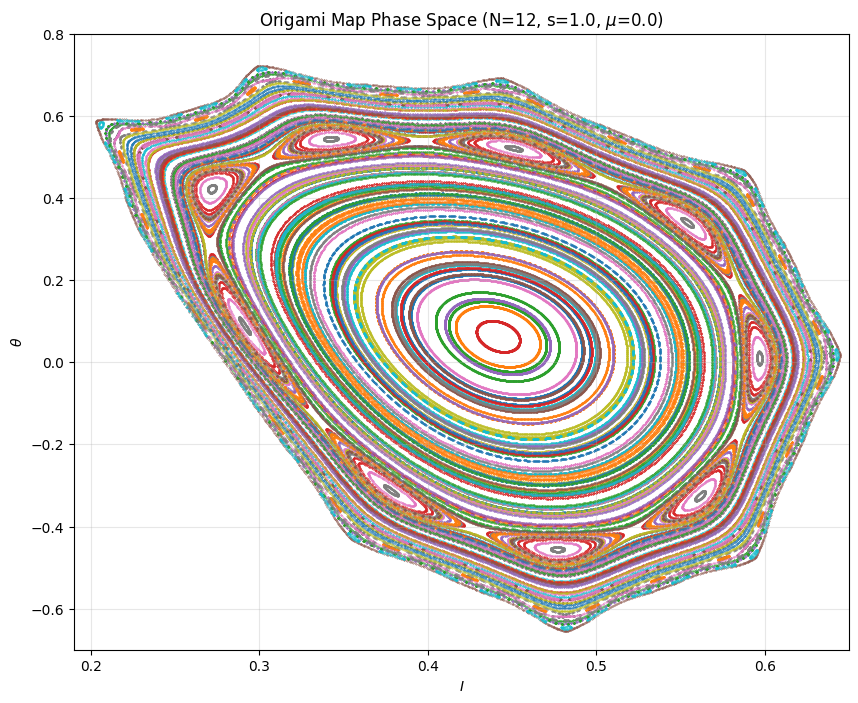

In [179]:
# --- Parameter Configuration (Case (A') in prior work) ---

params_A = {
    "m": 3,
    "N": 12,
    "s": 1.0,
    "mu": 0.0,
    "l_L": [0.72, 1, 1.1],
    "l_M": [0.70, 0.620284, 1.4],
    "l_R": [0.72, 1, 0.90],
    "sigma": [1, 1, 1], #M, M, M
    "k": [0, 0, 0],

    "plot_config": {
        "theta_range": [-0.7, 0.8],
        "I_range": [0.19, 0.65],
        "x_axis": "I",            #Note that $I$ and $\theta$ are swapped.
        "iterations": 2000
    },

    "initial_conditions": {
        "type": "grid",
        "theta_range": [-0.7, 0.8],
        "theta_steps": 16,
        "I_range": [0.19, 0.65],
        "I_steps": 16
    }
}

# Run the simulation
run_origami_simulation(params_A)

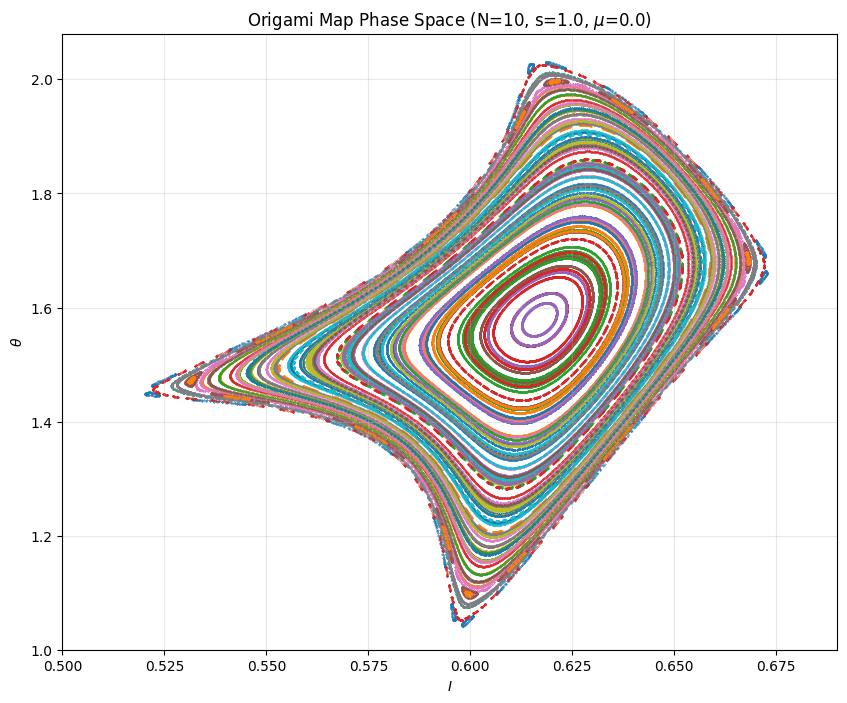

In [180]:
# --- Parameter Configuration (Case (B') in prior work) ---

params_B = {
    "m": 3,
    "N": 10,
    "s": 1.0,
    "mu": 0.0,
    "l_L": [1, 0.7, 1.1],
    "l_M": [0.5, 0.95, 1.2],
    "l_R": [1.33, 0.851, 1.2],
    "sigma": [1, 1, -1], #M, M, V
    "k": [0, 0, 0],

    "plot_config": {
        "theta_range": [1, 2.08],
        "I_range": [0.50, 0.69],
        "x_axis": "I",            #Note that $I$ and $\theta$ are swapped.
        "iterations": 2000
    },

    "initial_conditions": {
        "type": "grid",
        "theta_range": [1, 2.08],
        "theta_steps": 20,
        "I_range": [0.50, 0.69],
        "I_steps": 20
    }
}

# Run the simulation
run_origami_simulation(params_B)

## $(\mathbf{f}_3 \circ \mathbf{f}_2 \circ \mathbf{f}_1 \circ \mathbf{f}_0)$: Verification for Cases (B) in Prior Work

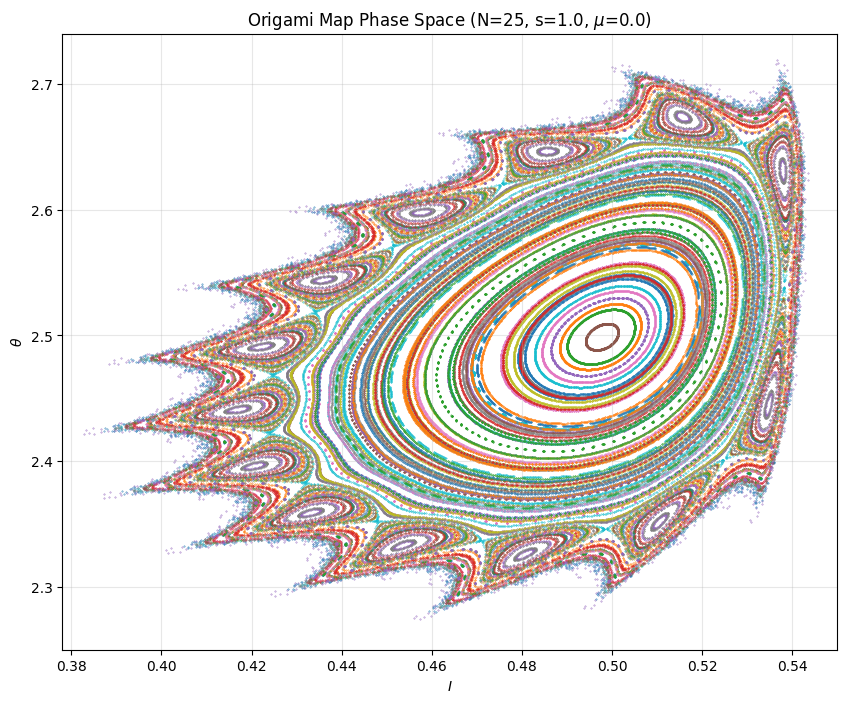

In [181]:
# --- Parameter Configuration (Case (B) in prior work) ---

params_B = {
    "m": 4,
    "N": 25,
    "s": 1.0,
    "mu": 0.0,
    "l_L": [1.03, 0.72, 0.88, 0.63],
    "l_M": [0.6675, 0.81, 0.75, 0.55],
    "l_R": [1.03, 0.72, 0.88, 0.63],
    "sigma": [1, -1, 1, -1], #M, M, V
    "k": [0, 0, 0, 0],

    "plot_config": {
        "theta_range": [2.25, 2.74],
        "I_range": [0.378, 0.55],
        "x_axis": "I",            #Note that $I$ and $\theta$ are swapped.
        "iterations": 1000
    },

    "initial_conditions": {
        "type": "grid",
        "theta_range": [2.25, 2.74],
        "theta_steps": 18,
        "I_range": [0.378, 0.55],
        "I_steps": 18
    }
}

# Run the simulation
run_origami_simulation(params_B)

## $(\mathbf{f}_3 \circ \mathbf{g}_2 \circ \mathbf{f}_2 \circ \mathbf{f}_1 \circ \mathbf{g}_0 \circ \mathbf{f}_0)$: Verification for Cases (B) in Prior Work

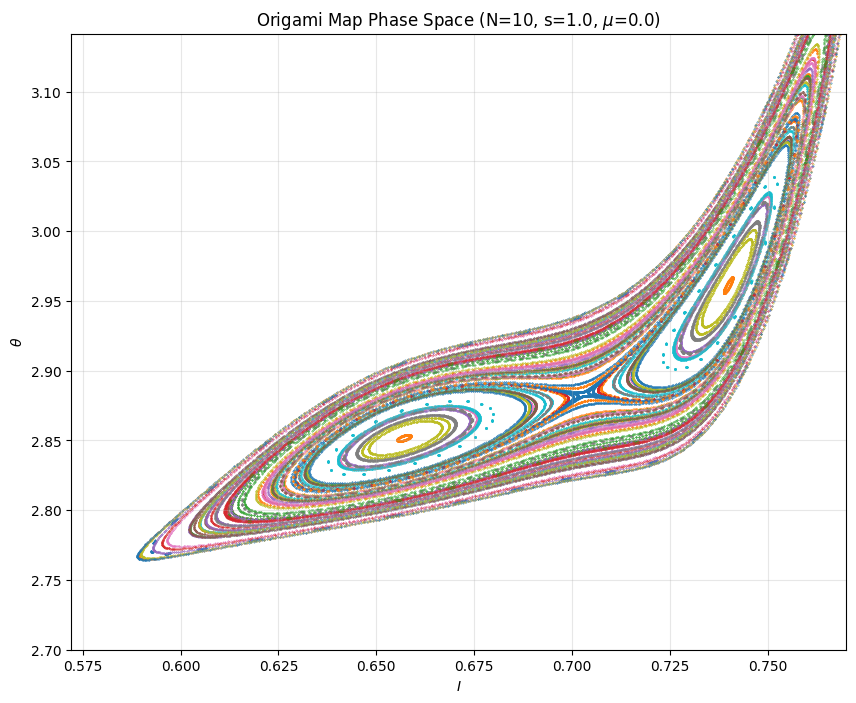

In [182]:
# --- Parameter Configuration (Case (B) in prior work) ---

params_B = {
    "m": 4,
    "N": 10,
    "s": 1.0,
    "mu": 0.0,
    "l_L": [0.89, 0.835, 1.055, 0.95],
    "l_M": [0.86, 0.67, 0.77, 0.815],
    "l_R": [0.89, 0.835, 1.055, 0.95],
    "sigma": [1, 1, 1, 1], #M, M, V
    "k": [1, 0, 1, 0],

    "plot_config": {
        "theta_range": [2.7, np.pi],
        "I_range": [0.572, 0.77],
        "x_axis": "I",            #Note that $I$ and $\theta$ are swapped.
        "iterations": 1000
    },

    "initial_conditions": {
        "type": "grid",
        "theta_range": [2.7, np.pi],
        "theta_steps": 20,
        "I_range": [0.572, 0.77],
        "I_steps": 20
    }
}

# Run the simulation
run_origami_simulation(params_B)

# Numerical Experiments for Our Study

Next, we provide the phase portraits for the parameter settings used in this study so that they can be easily checked below. Note that, unlike the previous numerical experiment, the horizontal axis is $\theta$.

## Setup of the frequency function

In [183]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def calc_theoretical_xi(I_vals, params):
    """
    Calculates the theoretical frequency profile xi(I) for the given parameters.
    The result is normalized to the range (-pi, pi].

    Correction:
    - Swapped assignments for r1 and r3 to match Eq. 3.20 in the thesis.
      r1 corresponds to l_next_R, and r3 corresponds to l_next_L.
    """
    m = params['m']
    l_L = np.array(params['l_L'])
    l_M = np.array(params['l_M'])
    l_R = np.array(params['l_R'])
    sigmas = np.array(params['sigma'])
    ks = np.array(params['k'])

    s_val = params.get('s', 1.0)

    xi_results = []

    for I in I_vals:
        total_xi = 0.0
        valid_point = True

        for i in range(m):
            next_i = (i + 1) % m

            # Apply scaling factor s only at the last step
            scale_factor = s_val if (i == m - 1) else 1.0

            # --- 【修正箇所】 r1 と r3 の割り当てを逆に変更 ---
            # Thesis Eq (3.20) implies: r1 <- l_next_R, r3 <- l_next_L
            r1 = l_R[next_i] * scale_factor
            r2 = l_M[next_i] * scale_factor
            r3 = l_L[next_i] * scale_factor
            # ---------------------------------------------------

            ll = l_L[i]
            lr = l_R[i]

            # Check valid domain
            if not (abs(ll - lr)/2 < I < (ll + lr)/2):
                valid_point = False
                break

            denom = 2 * ll * (2 * I)
            if denom == 0:
                valid_point = False; break

            alpha_val = (ll**2 + (2 * I)**2 - lr**2) / denom

            val_sq = 1 - alpha_val**2
            if val_sq < 0:
                valid_point = False; break
            beta_val = np.sqrt(val_sq)

            e1 = (r1**2 + ll**2 - r2**2) / (2 * ll)

            num_e2 = r1**2 - r3**2 + 4*I**2 - 4*I*e1*alpha_val
            den_e2 = 4 * I * beta_val
            if den_e2 == 0:
                valid_point = False; break
            e2 = num_e2 / den_e2

            gamma = r1**2 - e1**2 - e2**2
            if gamma < 0:
                valid_point = False; break
            e3 = sigmas[i] * np.sqrt(gamma)

            # Local rotation angle
            A = -e1 * beta_val + e2 * alpha_val
            B = e3
            xi_f = np.arctan2(B, A)

            total_xi += xi_f

            if ks[i] == 1:
                total_xi += np.pi

        if valid_point:
            # Normalize to (-pi, pi]
            total_xi = (total_xi + np.pi) % (2 * np.pi) - np.pi
            xi_results.append(total_xi)
        else:
            xi_results.append(np.nan)

    return np.array(xi_results)

def run_frequency_analysis(params):
    """
    Runs the frequency analysis, identifying zero-crossings and extrema,
    and plots the profile xi(I) vs I with detailed legends.
    """
    I_rng = params['plot_config']['I_range']
    # Use higher resolution for accurate detection
    I_vals = np.linspace(I_rng[0], I_rng[1], 60000)

    xi_vals = calc_theoretical_xi(I_vals, params)

    # Mask for valid numbers (ignore NaNs)
    valid_mask = ~np.isnan(xi_vals)
    if not np.any(valid_mask):
        print("No valid frequency values found in the given range.")
        return

    I_valid = I_vals[valid_mask]
    xi_valid = xi_vals[valid_mask]

    plt.figure(figsize=(10, 6))
    plt.plot(I_valid, xi_valid, color='green', linewidth=2, label=r'Theoretical $\xi(I)$')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

    # --- 1. Detect Zero Crossings (xi = 0) ---
    signs = np.sign(xi_valid)
    sign_diff = np.diff(signs)
    # Indices where sign changes
    zero_indices = np.where(sign_diff != 0)[0]

    for idx in zero_indices:
        # Linear interpolation to find more precise I where xi=0
        y1, y2 = xi_valid[idx], xi_valid[idx+1]
        x1, x2 = I_valid[idx], I_valid[idx+1]
        if y1 != y2:
            I_zero = x1 - y1 * (x2 - x1) / (y2 - y1)
            label_str = rf"$\xi=0$ at $I \approx {I_zero:.4f}$"
            plt.plot(I_zero, 0, 'bo', markersize=8, label=label_str)

    # --- 2. Detect Extrema (Shearless Points) ---
    # Calculate gradient
    grad = np.gradient(xi_valid)
    # Find where gradient changes sign
    grad_signs = np.sign(grad)
    grad_diff = np.diff(grad_signs)
    extrema_indices = np.where(grad_diff != 0)[0]

    for idx in extrema_indices:
        # Check if it is a real extremum or just numerical noise
        # (Filter out very small changes if necessary, but here we plot all)
        I_ext = I_valid[idx]
        xi_ext = xi_valid[idx]

        # Determine Max or Min
        ext_type = "Max" if grad[idx] > 0 else "Min"

        # Avoid labeling endpoints or sharp jumps (discontinuities from normalization)
        # Check continuity: if change is too large, it might be a wrap-around
        if idx > 0 and idx < len(xi_valid) - 1:
            jump = abs(xi_valid[idx+1] - xi_valid[idx-1])
            if jump > 1.0: # Threshold for discontinuity (e.g. pi jump)
                continue

        label_str = rf"{ext_type} at $I \approx {I_ext:.4f}$"
        plt.plot(I_ext, xi_ext, 'r*', markersize=10, label=label_str)

    plt.xlabel(r"$I$")
    plt.ylabel(r"$\xi(I)$")
    plt.title(f"Frequency Profile (m={params['m']})")
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize='small')
    plt.show()

## $(\mathbf{f}_2 \circ \mathbf{f}_1 \circ \mathbf{f}_0)$: Verification in our Work

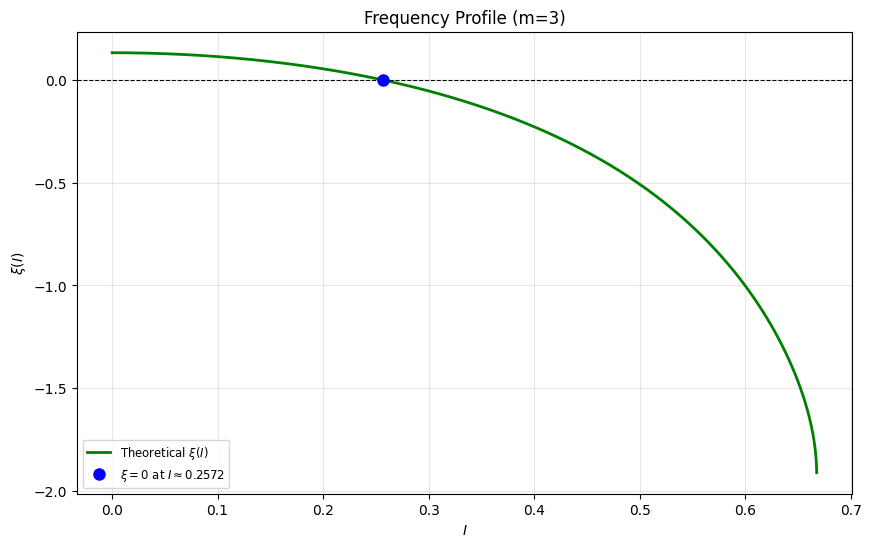

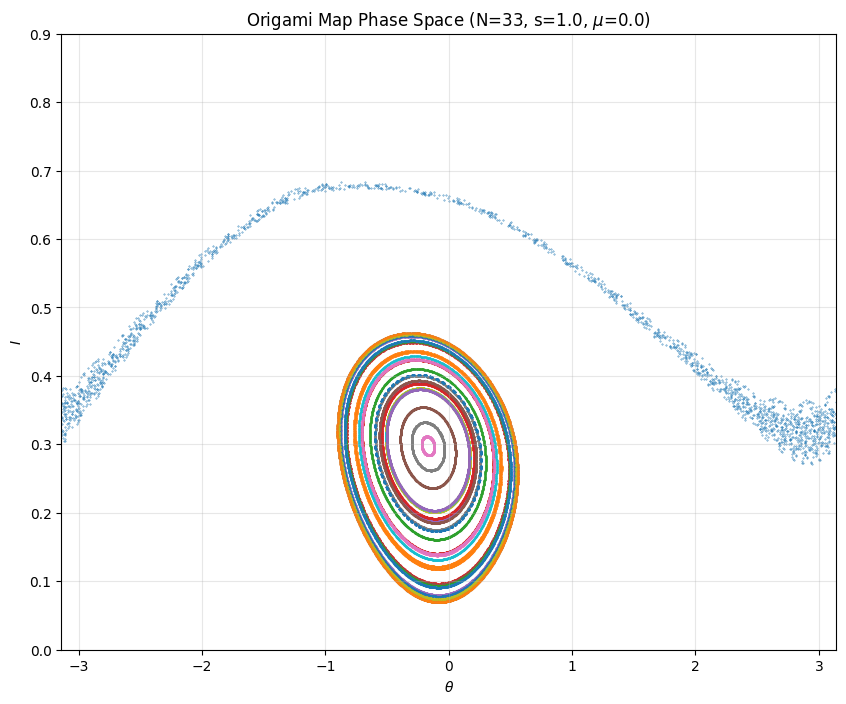

In [184]:
params_numerical1 = {
    "m": 3,
    "N": 33,
    "s": 1.0,
    "mu": 0.0,
    "l_L": [0.75, 1.11, 0.90],
    "l_M": [0.69, 0.58, 1.49],
    "l_R": [0.75, 1.11, 0.90],
    "sigma": [1, 1, 1], #M, M, M
    "k": [0, 0, 0],

    "plot_config": {
        "theta_range": [-np.pi, np.pi],
        "I_range": [0.0, 0.9],
        "x_axis": "theta",            #Note that $I$ and $\theta$ are swapped.
        "iterations": 2000
    },

    "initial_conditions": {
        "type": "grid",
        "theta_range": [-np.pi, np.pi],
        "theta_steps": 20,
        "I_range": [0.0, 0.9],
        "I_steps": 20
    }
}

# Run the simulation
run_frequency_analysis(params_numerical1)
run_origami_simulation(params_numerical1)

## $(\mathbf{f}_3 \circ \mathbf{g}_2 \circ \mathbf{f}_2 \circ \mathbf{f}_1 \circ \mathbf{g}_0 \circ \mathbf{f}_0)$: Verification in our Work

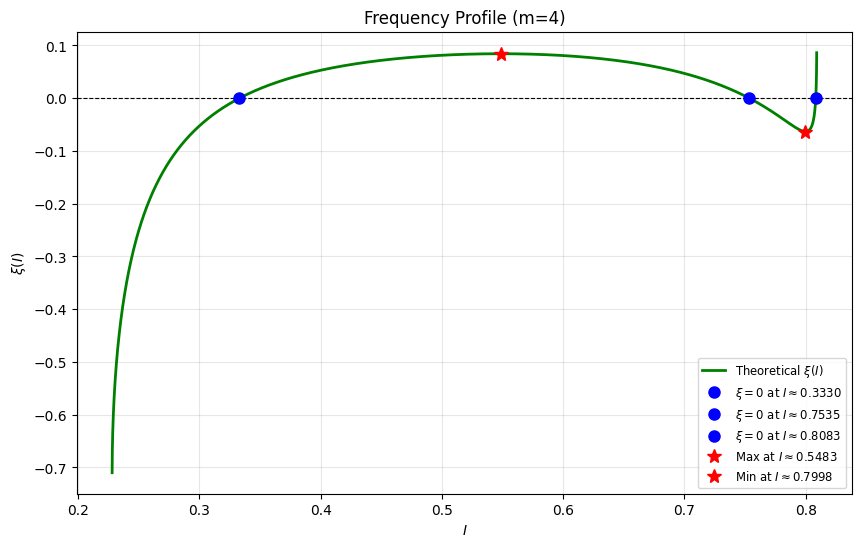

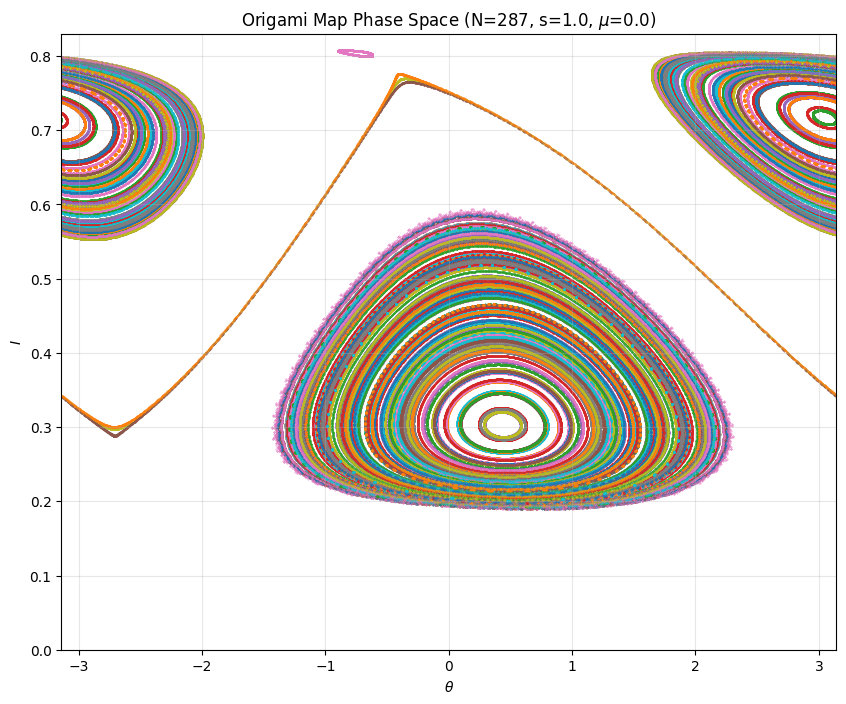

In [185]:
params_numerical2 = {
    "m": 4,
    "N": 287,
    "s": 1.0,
    "mu": 0.0,
    "l_R": [0.8552, 1.1342, 1.1932, 0.9105],
    "l_M": [0.9913, 1.1798, 0.9922, 0.9236],
    "l_L": [0.9748, 1.0774, 0.8522, 1.0664],
    "sigma": [-1, -1, 1, 1], #VVMM
    "k": [1, 0, 1, 0],

    "plot_config": {
        "theta_range": [-np.pi, np.pi],
        "I_range": [0.0, 0.83],
        "x_axis": "theta",            #Note that $I$ and $\theta$ are swapped.
        "iterations": 2000
    },

    "initial_conditions": {
        "type": "grid",
        "theta_range": [-np.pi, np.pi],
        "theta_steps": 30,
        "I_range": [0.0, 0.83],
        "I_steps": 30
    }
}

# Run the simulation
run_frequency_analysis(params_numerical2)
run_origami_simulation(params_numerical2)

## Conformally Symplectic

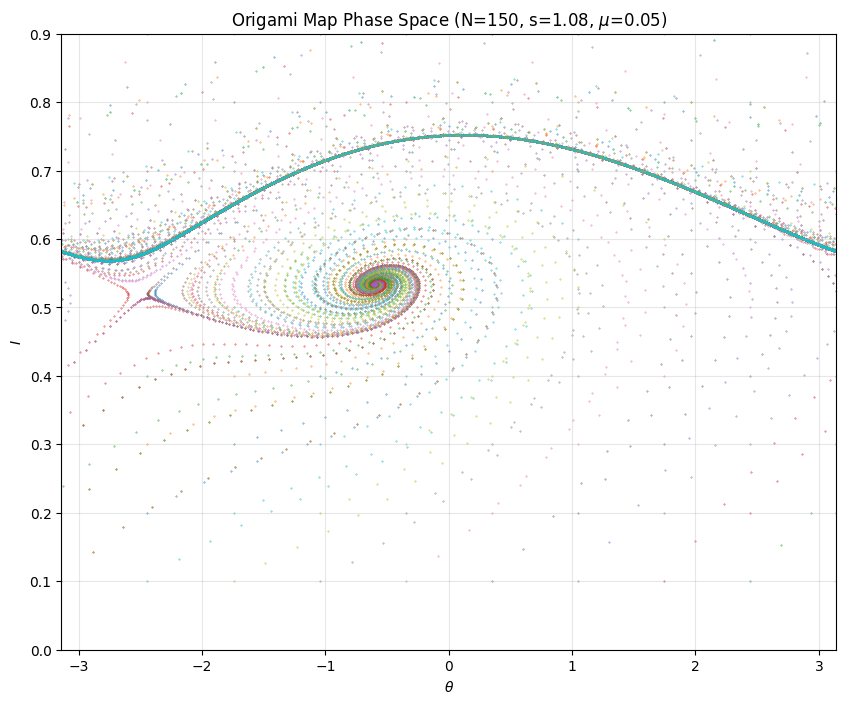

In [188]:
params_numerical_conformally = {
    "m": 3,
    "N": 150,
    "s": 1.08,
    "mu": 0.05,
    "l_L": [1.0, 1.41421356237, 1.41421356237],
    "l_M": [0.91, 0.91, 1.91],
    "l_R": [1.0, 1.41421356237, 1.41421356237],
    "sigma": [1, 1, 1], #M, M, M
    "k": [0, 0, 0],

    "plot_config": {
        "theta_range": [-np.pi, np.pi],
        "I_range": [0.0, 0.9],
        "x_axis": "theta",            #Note that $I$ and $\theta$ are swapped.
        "iterations": 2000
    },

    "initial_conditions": {
        "type": "grid",
        "theta_range": [-np.pi, np.pi],
        "theta_steps": 10,
        "I_range": [0.0, 0.9],
        "I_steps": 10
    }
}

# Run the simulation
run_origami_simulation(params_numerical_conformally)